### Importo as bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dt
import matplotlib.pyplot as plt
from pandas.plotting import table
import Functions as fn

### Importo os dados dos setores

In [2]:
# Importo a plan com os dados dos setores e ações
sectors_df = pd.read_csv('setores.csv')

# Transformo em um dicionário
sectors = dict((k, v.dropna().to_dict()) for k, v in pd.compat.iteritems(sectors_df))

In [3]:
# Faço uma lista com todas as ações
stocks = []

for sector in range(0, len(sectors.values())):
    for stock in range(0, len(list(sectors.values())[sector])):
        stocks.append(list(sectors.values())[sector][stock])

### Puxamos os dados do yahoo

In [4]:
# Defino qual será a data de início dos dataframes de preços
start_date = '2020-01-29'

# Crio um dicionário que irá conter a série de preços de cada ação
prices = {}

# Pego apenas a coluna Adjusted Close porque é o que me interessa
for s in range(0, len(stocks)):
    prices.update({stocks[s]:dt.DataReader(stocks[s], start=start_date, data_source='yahoo')['Adj Close']})

In [5]:
# Crio uma lista de preços que irá conter um pd.Series de preços para cada ação 
prices_list = []
for stock in prices.keys():
    prices_list.append(prices[stock])

In [6]:
# Agrupo os preços em apenas um dataframe
prices_df = pd.concat(prices_list, axis=1)

# Nomeio as colunas com os nomes dos tickers buscados
prices_df.columns = stocks

### Tratando a base de dados

In [7]:
# Crio uma função
def fill_values(df):
    '''
    Função que preenche valores descontínuos
    Params:
        df: dataframe de preços
    '''
    for i in df.columns.values:
        init = df[i].first_valid_index()
        end = df[i].last_valid_index()
        df[i].loc[init:end]=df[i].loc[init:end].fillna(method='ffill')

In [8]:
# Preencho os valores descontinuos de precos
fill_values(prices_df)

### Calculando os retornos dos setores

In [9]:
# Calculo os retornos diarios de cada acao
daily_returns = prices_df.pct_change()

In [10]:
# Faco um dicionario com os retornos diarios de cada setor
sector_returns = {}
for column in list(sectors_df.columns):
    stocks_list = list(sectors_df[column].dropna())
    number = len(stocks_list)
    returns = daily_returns[list(sectors_df[column].dropna())].sum(axis=1)/number
    sector_returns.update({column:returns})

In [11]:
# Crio uma lista de retornos que irá conter um pd.Series de retornos para cada setor
return_list = []
for sector in sector_returns.keys():
    return_list.append(sector_returns[sector])

In [12]:
# Agrupo os retornos em apenas um dataframe
returns_df = pd.concat(return_list, axis=1)

# Nomeio as colunas com os nomes dos setores
returns_df.columns = list(sectors_df.columns) 

#Calculo a performance
performance = returns_df.add(1).cumprod()

In [13]:
# Calculo os retornos mensais
monthly_returns = performance.groupby(performance.index.month).tail(1).pct_change()

### Visualizando os dados

c:\users\felipe\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


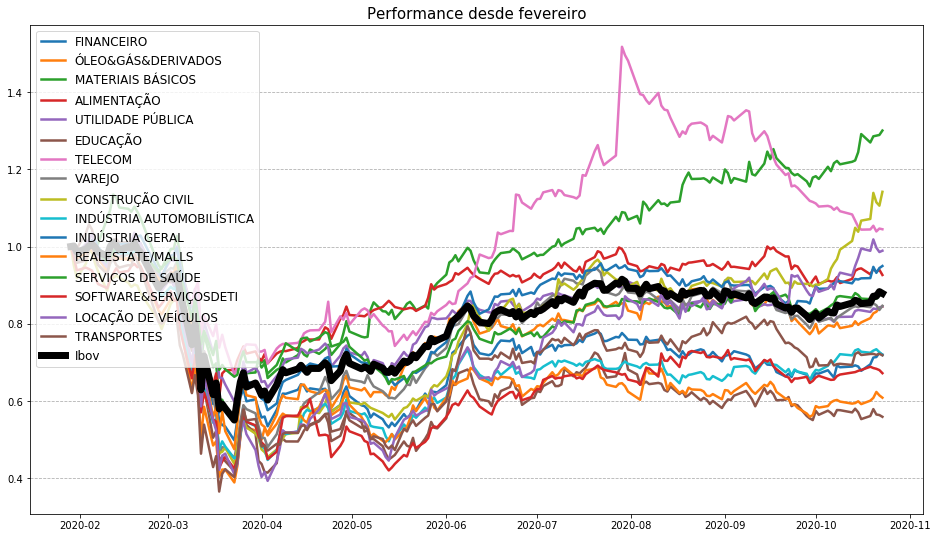

In [14]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(performance.drop('Ibov', axis=1), linewidth=2.5)
ax.plot(performance['Ibov'], color='black', linewidth=7)
ax.plot()
#ax.plot(portfolio_performance, label='Portfolio', color='black')
ax.legend(list(performance.columns), loc='best', fontsize=12)
ax.set_title('Performance desde fevereiro', fontsize=15)
plt.grid(linestyle='--', axis='y')
plt.show()

In [15]:
# Vejo quais foram os melhores e piores setores do mes escolhido
mes = 9

ix = monthly_returns['2020-'+str(mes)].index.values[0]
top3 = monthly_returns['2020-'+str(mes)].T.sort_values(ix).tail(3)
bottom3 = monthly_returns['2020-'+str(mes)].T.sort_values(ix).head(3)
ibov = performance.loc['2020-'+str(mes), 'Ibov']/performance.loc['2020-'+str(mes), 'Ibov'].iloc[0]

In [16]:
top_perfs = performance.loc['2020-' + str(mes), list(top3.index)+list(bottom3.index)]
top_perfs = (top_perfs/top_perfs.iloc[0])

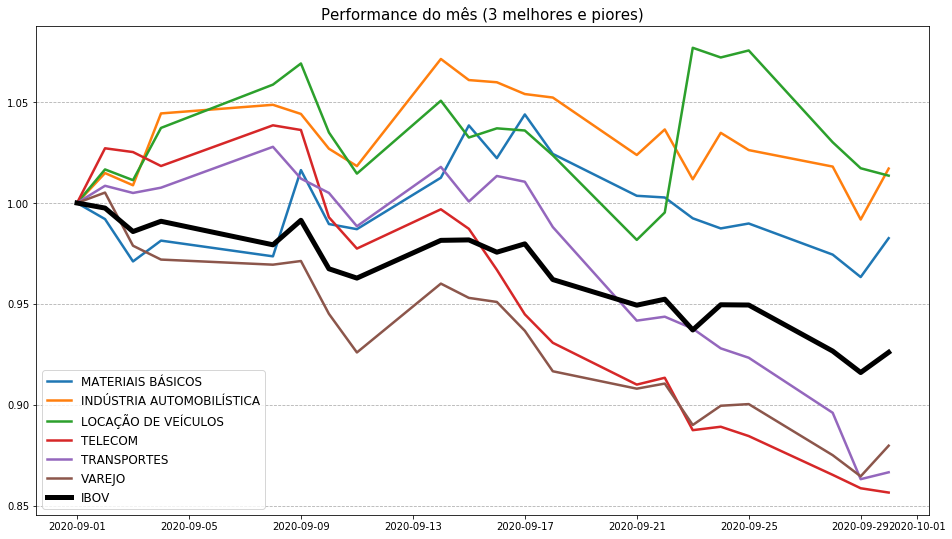

In [17]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(top_perfs, linewidth=2.5)
ax.plot(ibov, color='black', linewidth=5)
ax.plot()
#ax.plot(portfolio_performance, label='Portfolio', color='black')
ax.legend(list(top_perfs.columns)+['IBOV'], loc='best', fontsize=12)
ax.set_title('Performance do mês (3 melhores e piores)', fontsize=15)
plt.grid(linestyle='--', axis='y')
plt.show()


### Portfolios randomicos

In [18]:
# Faco um dicionario com os retornos diarios de cada portfolio randomico
#prices_df = prices_df.drop('^BVSP', axis=1)

random_returns = {}
number = 10
n_test = 10000
for i in range(0, n_test):
    random_tickers = list(prices_df.drop('^BVSP', axis=1).columns[list(np.random.randint(0, len(stocks)-1, number))])
    returns = daily_returns[random_tickers].sum(axis=1)/number
    random_returns.update({i:returns})

In [19]:
# Crio uma lista de retornos que irá conter um pd.Series de retornos para cada portfolio
return_list = []
for i in range(0, n_test):
    return_list.append(random_returns[i])

In [20]:
# Agrupo os retornos em apenas um dataframe
rand_returns_df = pd.concat(return_list, axis=1)

# Nomeio as colunas com os nomes dos setores
rand_returns_df.columns = list(range(0, n_test)) 

#Calculo a performance
rand_performance = rand_returns_df.add(1).cumprod()

In [21]:
# Vejo quantos foram melhor e pior que o ibov
win = rand_performance.tail(1)[rand_performance.tail(1)>((prices_df['^BVSP']/prices_df['^BVSP'].iloc[0])).tail(1)[0]].count(axis=1)
loose = rand_performance.tail(1)[rand_performance.tail(1)<((prices_df['^BVSP']/prices_df['^BVSP'].iloc[0])).tail(1)[0]].count(axis=1)


In [22]:
win/n_test

Date
2020-10-23    0.4623
dtype: float64

In [23]:
loose/n_test

Date
2020-10-23    0.5377
dtype: float64

In [24]:
# Calculo os retornos mensais
monthly_returns = rand_performance.groupby(performance.index.month).tail(1).pct_change()

In [25]:
# Vejo quais foram os melhores e piores setores do mes escolhido
mes = 9

ix = monthly_returns['2020-'].index.values[0]
top3 = rand_performance.tail(1).T.sort_values('2020-10-19').tail(10).index
bottom3 = rand_performance.tail(1).T.sort_values('2020-10-19').head(10).index
ibov = performance.loc['2020-', 'Ibov']/performance.loc['2020-', 'Ibov'].iloc[0]

KeyError: '2020-10-19'

In [ ]:
top_perfs = rand_performance.loc['2020-', list(top3)+list(bottom3)]
top_perfs = (top_perfs/top_perfs.iloc[0])

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(top_perfs, linewidth=2.5)
ax.plot(ibov, color='black', linewidth=5)
ax.plot()
#ax.plot(portfolio_performance, label='Portfolio', color='black')
ax.legend(list(top_perfs.columns)+['IBOV'], loc='best', fontsize=12)
ax.set_title('Performance do mês (5 melhores e piores)', fontsize=15)
plt.grid(linestyle='--', axis='y')
plt.show()
